In [ ]:
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import os
import pandas as pd
from pyoso import Client

load_dotenv()
OSO_API_KEY = os.environ['OSO_API_KEY']
client = Client(api_key=OSO_API_KEY)
stringify = lambda arr: "'" + "','".join(arr) + "'"


In [ ]:
DATE = '2025-05-01'


In [ ]:
df_models = client.to_pandas(f"""
WITH model_patterns AS (
  SELECT 
    model_name,
    rendered_at,
    CASE
      WHEN regexp_like(model_name, '^int_events__(?!daily).*') THEN 'time'
      WHEN regexp_like(model_name, '^int_events_daily__.*') THEN 'bucket_day'
      WHEN model_name = 'stg_github__events' THEN 'created_at'
      WHEN regexp_like(model_name, '^stg_superchain__.*') THEN 'block_timestamp'
      WHEN regexp_like(model_name, '^stg_worldchain__.*') THEN 'block_timestamp'
    END as date_column
  FROM models_v0
  WHERE rendered_at > DATE('{DATE}')
),
filtered_models AS (
  SELECT 
    model_name,
    rendered_at
  FROM model_patterns
  WHERE date_column IS NOT NULL
)
SELECT * FROM filtered_models
ORDER BY model_name
""")
df_models


,model_name,rendered_at
0,int_events_to_project__github,2025-05-01 00:14:00.501
1,int_events_filtered__github,2025-05-01 00:14:04.180
2,int_events_monthly_to_project__github,2025-05-01 00:14:02.011
3,int_events_daily_to_project__github,2025-05-01 00:14:03.821
4,int_events_weekly__github,2025-05-01 00:14:02.716
5,int_events__funding,2025-05-01 00:13:57.763
6,int_events_daily_to_project__defillama_tvl,2025-06-01 00:27:45.399
7,int_events_aux_issues,2025-06-01 00:27:49.792
8,stg_superchain__deployers,2025-06-01 00:27:08.738
9,int_events_daily__gitcoin_funding,2025-06-01 00:27:47.799


In [ ]:
i = 0
results = []
for model_keyword, date_col in INCREMENTAL_MODEL_KEYWORDS.items():
    if '%' in model_keyword:
        model_keyword = model_keyword[:-1]
    model_list = df_models[df_models['model_name'].str.startswith(model_keyword)]['model_name'].unique()
    for model in model_list:
        print(i, model, date_col)
        i += 1
        try:
            result = client.to_pandas(f"""
                SELECT
                  DATE({date_col}) AS bucket_day,
                  COUNT(*) as {model}
                FROM {model}
                WHERE {date_col} >= DATE('{DATE}')
                GROUP BY 1
                ORDER BY 1
            """)
            result.set_index('bucket_day', inplace=True)
            results.append(result)
            print(f"Found {len(result)} dates.")
        except Exception as e:
            print(e)
        print()


0 int_events__funding time
400 Client Error: Bad Request for url: https://www.opensource.observer/api/v1/sql - TABLE_NOT_FOUND: line 5:22: Table 'iceberg.oso.int_events__funding' does not exist

1 int_events__4337 time
Found 32 dates.

2 int_events__blockchain time
Found 32 dates.

3 int_events__gitcoin_funding time
Found 12 dates.

4 int_events__open_collective_funding time
Found 23 dates.

5 int_events__blockchain_token_transfers time
Found 31 dates.

6 int_events__github time
Found 35 dates.

7 int_events_daily__gitcoin_funding bucket_day
Found 12 dates.

8 int_events_daily__defillama_tvl bucket_day
Found 35 dates.

9 int_events_daily__github_with_lag bucket_day
Found 35 dates.

10 int_events_daily__open_collective_funding bucket_day
Found 23 dates.

11 int_events_daily__funding bucket_day
Found 29 dates.

12 int_events_daily__blockchain bucket_day
Found 32 dates.

13 int_events_daily__blockchain_token_transfers bucket_day
Found 31 dates.

14 int_events_daily__4337 bucket_day
Found 

/var/folders/gh/1v87rt9j01gcjctn3v95bqkw0000gn/T/ipykernel_53704/2059138102.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_hm = pd.concat(normalized_results, axis=1).fillna(0)


<Axes: >

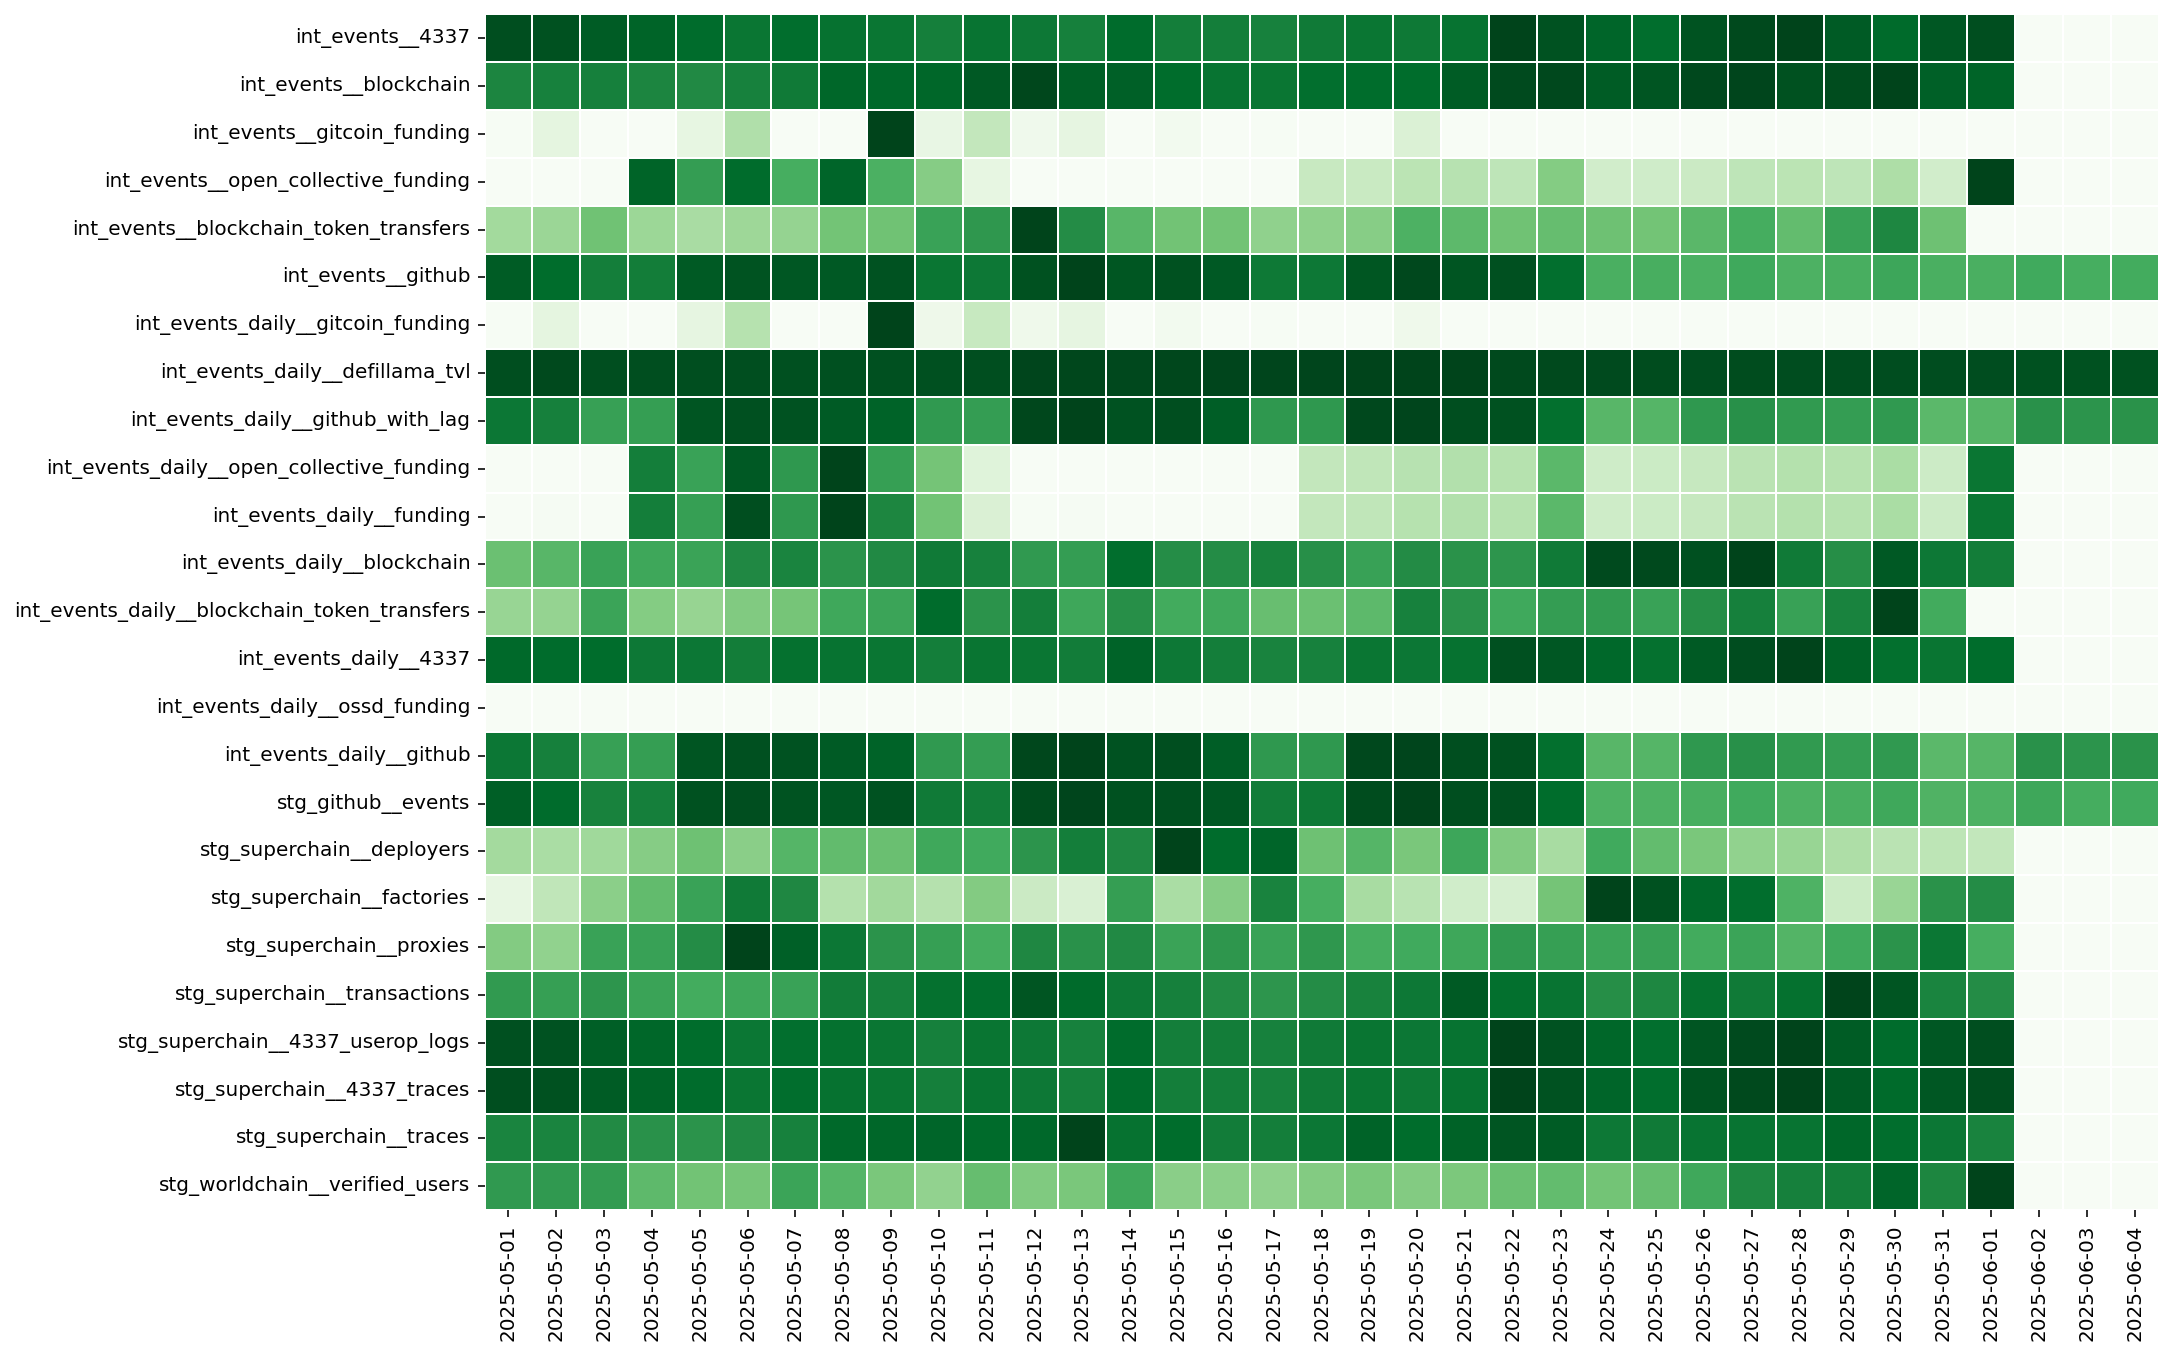

In [ ]:
import seaborn as sns

normalized_results = [r / r.max() for r in results]
df_hm = pd.concat(normalized_results, axis=1).fillna(0)
df_hm = df_hm.map(pd.to_numeric)
df_hm.sort_index(inplace=True)
df_hm.index = [f'{d}' for d in df_hm.index]

fig, ax = plt.subplots(figsize=(15,15), dpi=144)
sns.heatmap(df_hm.T, cmap='Greens', square=True, lw=1, cbar=False, ax=ax)
